In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error as mse, precision_score, recall_score
from sklearn import utils

from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve
from scikitplot.estimators import plot_learning_curve, plot_feature_importances

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from collections import defaultdict 

import gc
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [2]:
train = pd.read_hdf('train_online_retail.h5').reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520142 entries, 0 to 520141
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       520142 non-null  int32         
 1   stock_code    520142 non-null  int16         
 2   description   517903 non-null  object        
 3   quantity      520142 non-null  int32         
 4   invoice_date  520142 non-null  datetime64[ns]
 5   price_unit    520142 non-null  float16       
 6   price_total   520142 non-null  float32       
 7   customer_id   520142 non-null  int16         
 8   country       520142 non-null  object        
 9   is_canceled   520142 non-null  bool          
 10  is_test       520142 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 21.8+ MB


In [3]:
train.head(20)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
0,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,False
1,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,False
2,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,False
3,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,False
4,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,False
5,2,17,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.450195,17.400000,1,United Kingdom,False,False
6,2,18,HEART IVORY TRELLIS LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,False
7,2,19,HEART FILIGREE DOVE LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,False
8,2,20,FULL ENGLISH BREAKFAST PLATE,16,2009-12-01 09:06:00,3.390625,54.240002,1,United Kingdom,False,False
9,2,21,PIZZA PLATE IN BOX,4,2009-12-01 09:06:00,3.750000,15.000000,1,United Kingdom,False,False


In [7]:
#loading the test dataset
test = pd.read_hdf('test_online_retail.h5').reset_index(drop=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547229 entries, 0 to 547228
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       547229 non-null  int32         
 1   stock_code    547229 non-null  int16         
 2   description   545086 non-null  object        
 3   quantity      547229 non-null  int32         
 4   invoice_date  547229 non-null  datetime64[ns]
 5   price_unit    547229 non-null  float16       
 6   price_total   547229 non-null  float32       
 7   customer_id   547229 non-null  int16         
 8   country       547229 non-null  object        
 9   is_test       547229 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 22.4+ MB


In [9]:
#checking the value counts of is_canceled column in train dataset ca. 98% to 2%
train['is_canceled'].value_counts(normalize=True).values * 100

array([98.0837925,  1.9162075])

In [10]:
#we can see that there are orders with multiple items, if only one item gets retailed then whole order is retailed
#we can see that value counts in aggregated dataset has different distribution of is_canceled value: 85% to 15%
train_agg = train.groupby('invoice').sum()
train_agg['is_canceled'] = (train_agg['is_canceled'] > 0).astype(np.int)
train_agg['is_canceled'].value_counts(normalize=True).values * 100

array([84.53792795, 15.46207205])

In [12]:
#using group kfold to prepare data for KFold cross validation (keeping different distribution)

X = train[['invoice', 'is_canceled']].values #simple training data
y = train['is_canceled'].values #target value in training data
groups = train['invoice'].values #grouping by invoice number so we have full orders in folds

X_shuffled, y_shuffled, groups_shuffled = utils.shuffle(X, y, groups) #shuffling the data

group_kfold = GroupKFold(n_splits=5)

for train_idx, test_idx in group_kfold.split(X_shuffled, y_shuffled, groups_shuffled):    
    sel_df = train[ train['invoice'].isin( groups_shuffled[test_idx]) ]
    
    print('Initial dataset with detailed items:')
    print( sel_df['is_canceled'].value_counts(normalize=True).values * 100)
    
    sel_df_agg = sel_df.groupby('invoice').sum()
    sel_df_agg['is_canceled'] = (sel_df_agg['is_canceled'] > 0).astype(np.int)
    
    print('Aggregated dataset:')
    print(sel_df_agg['is_canceled'].value_counts(normalize=True).values * 100)
    
    print("=====\n\n")

Initial dataset with detailed items:
[97.90731431  2.09268569]
Aggregated dataset:
[84.07607682 15.92392318]
=====


Initial dataset with detailed items:
[98.17454748  1.82545252]
Aggregated dataset:
[84.95245199 15.04754801]
=====


Initial dataset with detailed items:
[98.16299458  1.83700542]
Aggregated dataset:
[84.80044759 15.19955241]
=====


Initial dataset with detailed items:
[98.18414273  1.81585727]
Aggregated dataset:
[84.31847846 15.68152154]
=====


Initial dataset with detailed items:
[97.98996424  2.01003576]
Aggregated dataset:
[84.54223382 15.45776618]
=====




In [14]:
#checking empty data
train.isnull().sum()

invoice            0
stock_code         0
description     2239
quantity           0
invoice_date       0
price_unit         0
price_total        0
customer_id        0
country            0
is_canceled        0
is_test            0
dtype: int64

In [15]:
#filling empty data with -1
train.fillna(-1, inplace=True)

In [20]:
#feats for the model
feats = train.select_dtypes(np.number, np.bool).columns
black_list = ['is_canceled', 'is_test', 'is_canceled_pred', 'total_return', 'total_return_pred']
    
feats = [feat for feat in feats if feat not in black_list]
feats

['invoice',
 'stock_code',
 'quantity',
 'price_unit',
 'price_total',
 'customer_id']

In [21]:
#data preparation
target = 'is_canceled' 
X = train[feats].values 
y = train[target].values
        
pred_feature = '{}_pred'.format(target) #new feature that we will predict (classification)
train[pred_feature] = np.nan #filling new feature with nan values

In [23]:
#model Dummy Classifier
model = DummyClassifier()

In [24]:
#Group KFold validation
groups = train['invoice']
index = train.index
X, y, groups, index = utils.shuffle(X, y, groups, index, random_state = 8888)

group_kfold = GroupKFold(n_splits = 5)

for train_idx, test_idx in group_kfold.split(X, y, groups):    
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test   = X[test_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    sel_index = train.index.isin(index[test_idx])
    train.loc[ sel_index , [pred_feature]] = y_pred
    
train[pred_feature] = train[pred_feature].astype('str')
train[pred_feature] = train[pred_feature]=='True'

In [27]:
#calculating mse metric on aggregated data
train_agg = train.groupby('invoice')[ ['price_total', 'is_canceled_pred', 'is_canceled'] ].sum()

train_agg['is_canceled'] = train_agg['is_canceled'] > 0
train_agg['is_canceled_pred'] = train_agg['is_canceled_pred'] > 0

train_agg['total_return'] = train_agg['price_total'] * train_agg['is_canceled']
train_agg['total_return_pred'] = train_agg['price_total'] * train_agg['is_canceled_pred']

print ('mse: ', mse( train_agg['total_return'].values,  train_agg['total_return_pred'].values))

mse:  2146768.0


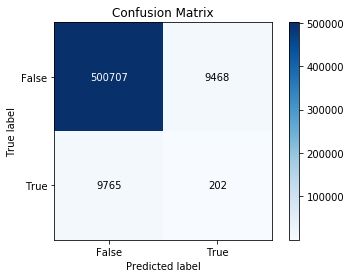

In [28]:
#plotting confusion matrix
plot_confusion_matrix(train['is_canceled'], train[pred_feature])

In [29]:
#plot feature importance
perm = PermutationImportance(model, random_state=8888).fit(X, y)
eli5.show_weights(perm, feature_names=feats)

Weight,Feature
-0.0001 ± 0.0002,quantity
-0.0003 ± 0.0001,stock_code
-0.0003 ± 0.0003,price_total
-0.0004 ± 0.0006,price_unit
-0.0004 ± 0.0002,invoice
-0.0004 ± 0.0003,customer_id


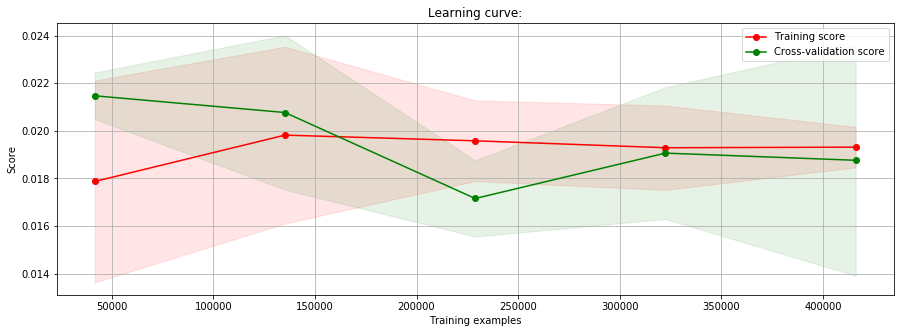

In [30]:
#plotting learning curve
title = 'Learning curve:'
plot_learning_curve(model, X, y, title=title, figsize=(15, 5), random_state=8888, cv=5, scoring='recall')
